<a href="https://colab.research.google.com/github/HowonRyu/ConfidenceSet/blob/main/example/Independent_Studies_2023Winter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import random
import sys
import os
import math
import scipy.stats
from tabulate import tabulate

!rm -rf ConfSets
!git clone https://github.com/TomMaullin/ConfSets.git
sys.path.append('/content/ConfSets/lib/')
from generateData import *
from boundary import *


!pip install git+https://github.com/HowonRyu/ConfidenceSet.git
from confidenceset.fdr_cope import *

Cloning into 'ConfSets'...
remote: Enumerating objects: 1412, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 1412 (delta 21), reused 20 (delta 9), pack-reused 1374
Receiving objects: 100% (1412/1412), 359.84 KiB | 4.50 MiB/s, done.
Resolving deltas: 100% (993/993), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/HowonRyu/ConfidenceSet.git to /tmp/pip-req-build-35scqohw
  Running command git clone --filter=blob:none --quiet https://github.com/HowonRyu/ConfidenceSet.git /tmp/pip-req-build-35scqohw
  Resolved https://github.com/HowonRyu/ConfidenceSet.git to commit fad6b708105cf9e19228facb839b9c0a215d45b9
  Preparing metadata (setup.py) ... done


# FDR Confidence Set


## Confidence Set controlling for FDR
\begin{array}{|c|c|} \hline
 & N & P &  \\ \hline
H_0 & TN & FP & m_0 \\
H_1 & FN & TP & m-m_0 \\ \hline
 & m-R & R & m \\ \hline
\end{array}


### Family Wise Error Rate (FWER)
*   $FWER = P(FP \ge 1 | H_0) = \frac{FP}{m_0}$
*   In multiple testing, use Bonferroni to control for: $FWER <\frac{\alpha}{m}$



### False Discovery Rate (FDR)

*   $FDR = E(\frac{FP}{R} | R>0)P(R>0) = E \frac{FP}{\max(1,R)} $
*  ((If you can add BH proof))

## Simulation

Different settings of image size and variance

In [179]:
# Circle/square mu and noise specs
mu_spec_circle_l_100 = {'type': 'circle2D', 
                  'center': np.array([0,0]), 
                  'fwhm': np.array([0,0]), 
                  'r': np.array(49), 
                  'mag': np.array(3)}

mu_spec_circle_s_100 = {'type': 'circle2D', 
                  'center': np.array([0,0]), 
                  'fwhm': np.array([0,0]), 
                  'r': np.array(25), 
                  'mag': np.array(3)}


mu_spec_circle_l_50 = {'type': 'circle2D', 
                  'center': np.array([0,0]), 
                  'fwhm': np.array([0,0]), 
                  'r': np.array(int(49/2)), 
                  'mag': np.array(3)}

mu_spec_circle_s_50 = {'type': 'circle2D', 
                  'center': np.array([0,0]), 
                  'fwhm': np.array([0,0]), 
                  'r': np.array( int(25/2)), 
                  'mag': np.array(3)}


noise_spec_homogen = {'FWHM': [0, 0, 0],
                      'mag': np.array(3),
                      'type': 'homogen'}                      

noise_spec_homogen_smth = {'FWHM': [0, 7, 7],
                           'mag': np.array(3),
                      'type': 'homogen'}                      


#image dimension
n_subj=80
img_dim=(50, 50)
field_dim = np.array((n_subj,) + img_dim)


#generating noise and mu
noise = get_noise(noise_spec_homogen, field_dim) 
noise_smth= get_noise(noise_spec_homogen_smth, field_dim)

mu_circular_l = get_mu(mu_spec_circle_l_50, field_dim)
mu_circular_s = get_mu(mu_spec_circle_s_50, field_dim)


#putting together noise and mu, noise ~ MVN(0,sigma=3)
circular_l = mu_circular_l + noise
circular_l_smth = mu_circular_l + noise_smth

circular_s = mu_circular_s + noise
circular_s_smth = mu_circular_s + noise_smth

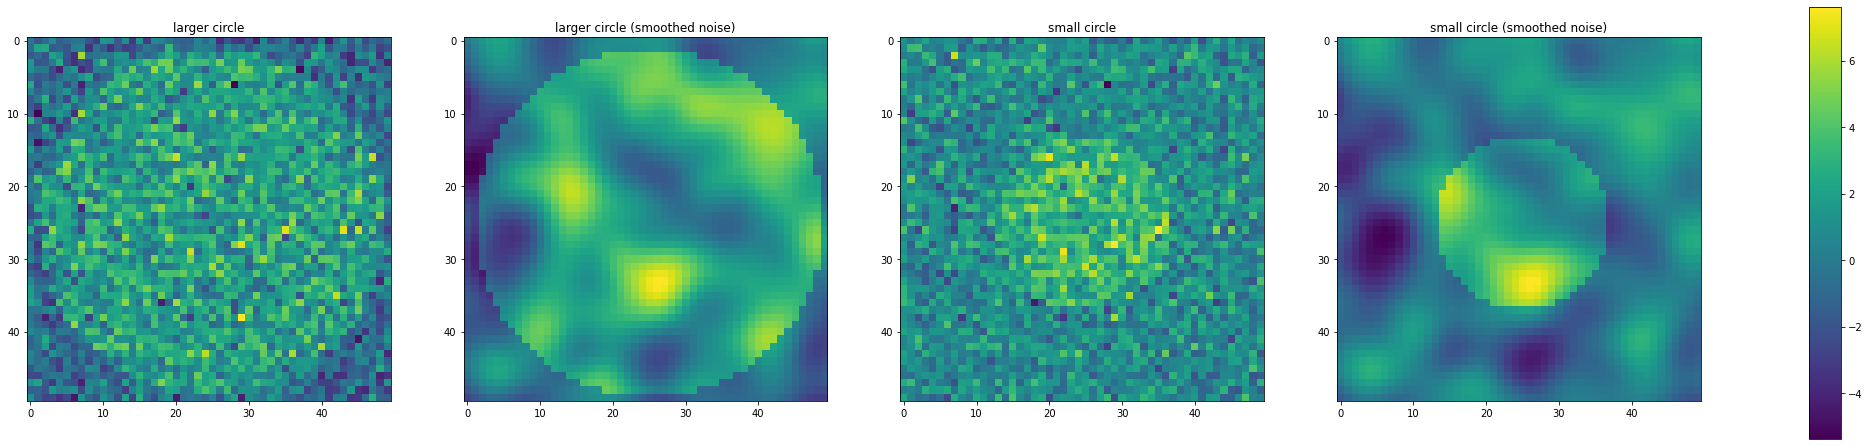

Noise uncorrelated for the default setting, default noise ~N(0, 2^2) 


In [177]:
fig, axs = plt.subplots(1, 4, figsize=(30, 20))


im = axs[0].imshow(circular_l[0,:,:])
axs[0].set_title("larger circle")
#plt.colorbar(im00, ax=axs[0, 0])

im = axs[1].imshow(circular_l_smth[0,:,:])
axs[1].set_title("larger circle (smoothed noise)")
#plt.colorbar(im01, ax=axs[0, 1])

im = axs[2].imshow(circular_s[0,:,:])
axs[2].set_title("small circle")
#plt.colorbar(im02, ax=axs[0, 2])

im = axs[3].imshow(circular_s_smth[0,:,:])
axs[3].set_title("small circle (smoothed noise)")
#plt.colorbar(im03, ax=axs[0, 3])

im = axs[0].imshow(circular_l[0,:,:])
axs[0].set_title("larger circle")
#plt.colorbar(im00, ax=axs[0, 0])

im = axs[1].imshow(circular_l_smth[0,:,:])
axs[1].set_title("larger circle (smoothed noise)")
#plt.colorbar(im01, ax=axs[0, 1])

im = axs[2].imshow(circular_s[0,:,:])
axs[2].set_title("small circle")
#plt.colorbar(im02, ax=axs[0, 2])

im = axs[3].imshow(circular_s_smth[0,:,:])
axs[3].set_title("small circle (smoothed noise)")
#plt.colorbar(im03, ax=axs[0, 3])

cbar_ax = fig.add_axes([0.95, 0.35, 0.015, 0.3])
fig.colorbar(im, cax=cbar_ax)
plt.show()

print("Noise uncorrelated for the default setting, default noise ~N(0, 3^2) ")

See how one-sided and two-sided tests and sub-setting for inner and outer confidence sets are constructd

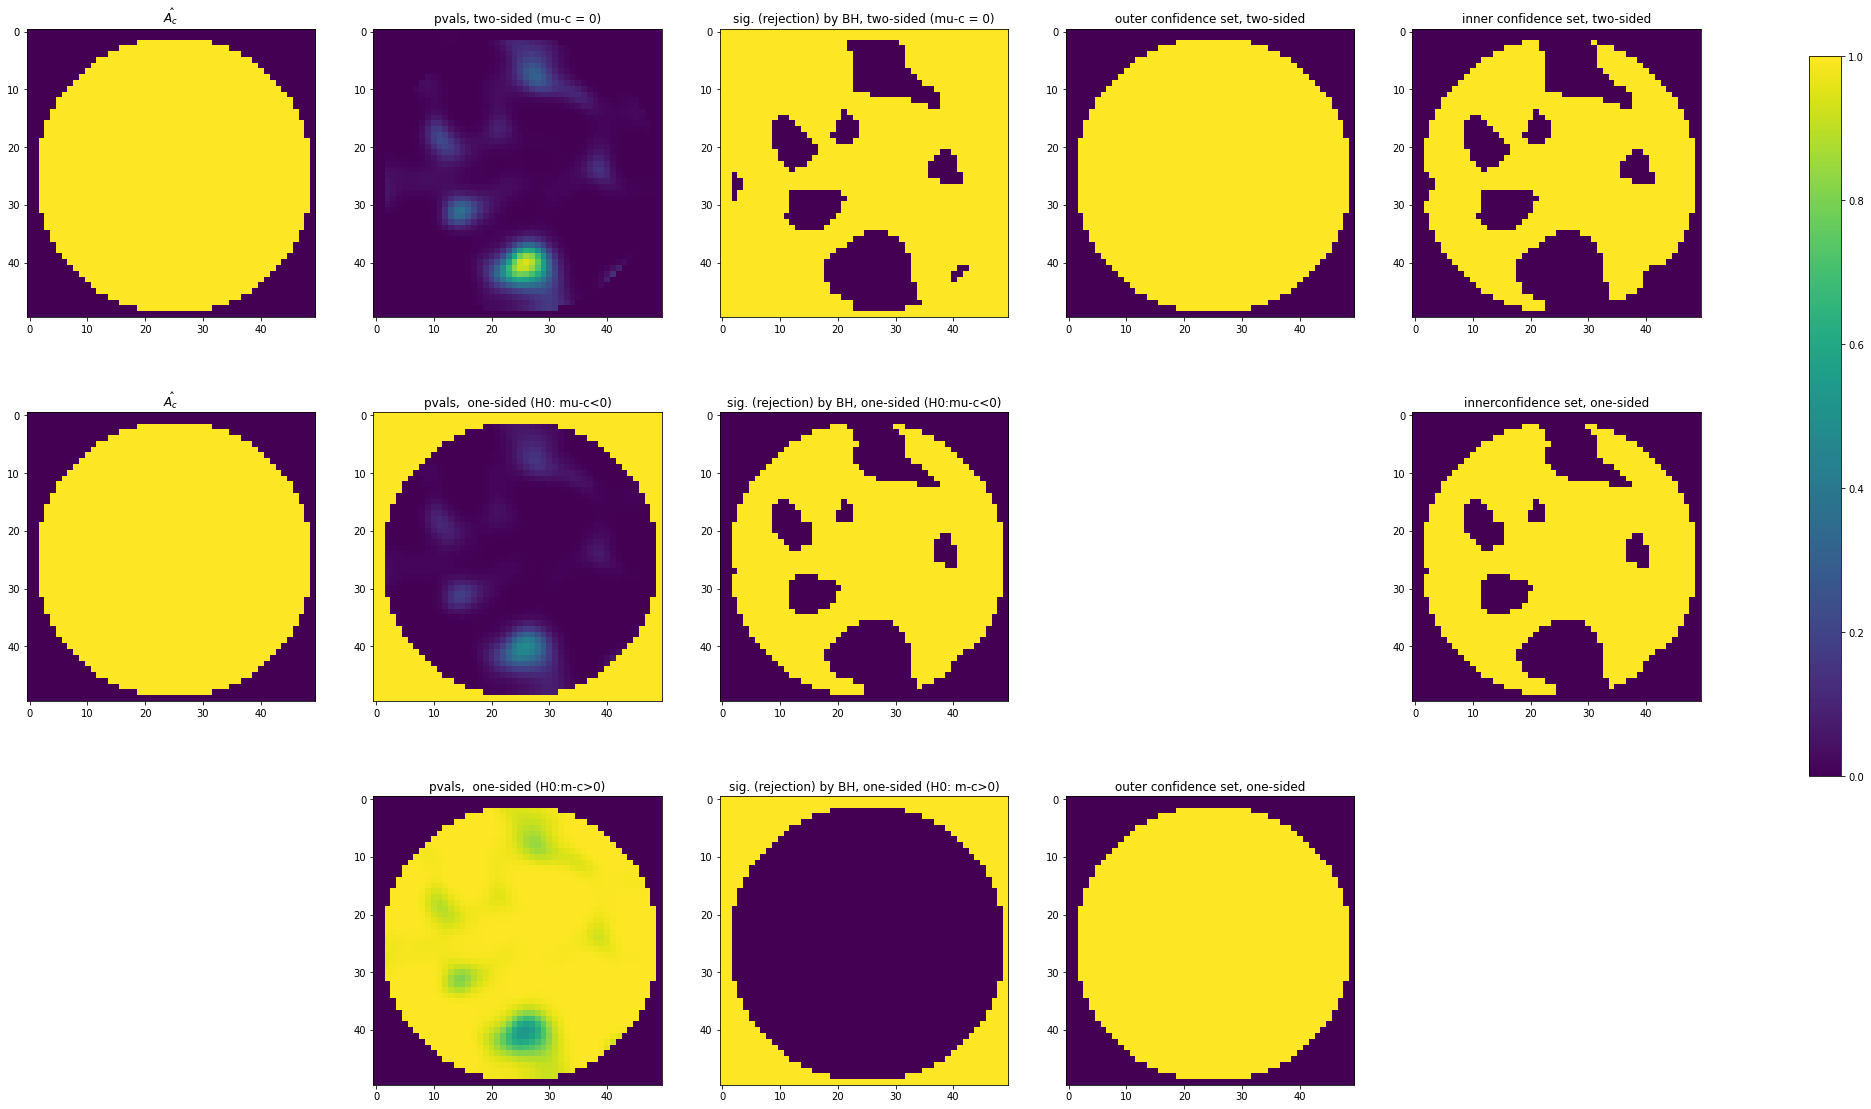

threshold = c = 2


In [180]:
data = circular_l_smth
threshold = 2
alpha = 0.05

data_tstat = mvtstat(data - threshold)
data_dim = data.shape

nsubj = data_dim[0]
Achat = data_tstat >= 0
Achat_C = data_tstat < 0

# two one-sided tests
inner_pvals = 1 - scipy.stats.t.cdf(data_tstat, df=nsubj - 1)
outer_pvals = scipy.stats.t.cdf(data_tstat, df=nsubj - 1)
inner_rejection_ind, _, _ = fdrBH(inner_pvals, alpha)
outer_rejection_ind, _, _ = fdrBH(outer_pvals, alpha)
outer_set_1 = 1- Achat_C*outer_rejection_ind
inner_set_1 = Achat*inner_rejection_ind


# a two sided test
pvals = 2*(1 - scipy.stats.t.cdf(abs(data_tstat), df=nsubj - 1))
rejection_ind, _, _ = fdrBH(pvals, alpha)
outer_set_2 = 1- Achat_C * rejection_ind
inner_set_2 = Achat*rejection_ind
  


fig, axs = plt.subplots(3, 5, figsize=(30, 20))

_min, _max = 0,1

im = axs[0, 0].imshow(Achat)
axs[0, 0].set_title("$\hat{A_c}$")
#plt.colorbar(im00, ax=axs[0, 0])

im = axs[1, 0].imshow(Achat)
axs[1, 0].set_title("$\hat{A_c}$")
#plt.colorbar(im00, ax=axs[0, 0])


im = axs[0, 1].imshow(pvals, vmin = _min, vmax = _max)
axs[0, 1].set_title("pvals, two-sided (mu-c = 0)")
#plt.colorbar(im02, ax=axs[0, 2])

im = axs[1, 1].imshow(inner_pvals, vmin = _min, vmax = _max)
axs[1, 1].set_title("pvals,  one-sided (H0: mu-c<0)")
#plt.colorbar(im03, ax=axs[0, 3])

im = axs[2, 1].imshow(outer_pvals, vmin = _min, vmax = _max)
axs[2, 1].set_title("pvals,  one-sided (H0:m-c>0)")
#plt.colorbar(im03, ax=axs[0, 3])




im = axs[0, 2].imshow(rejection_ind, vmin = _min, vmax = _max)
axs[0, 2].set_title("sig. (rejection) by BH, two-sided (mu-c = 0)")
#plt.colorbar(im02, ax=axs[0, 2])

im = axs[1, 2].imshow(inner_rejection_ind, vmin = _min, vmax = _max)
axs[1, 2].set_title("sig. (rejection) by BH, one-sided (H0:mu-c<0)")
#plt.colorbar(im03, ax=axs[0, 3])

im = axs[2, 2].imshow(outer_rejection_ind, vmin = _min, vmax = _max)
axs[2, 2].set_title("sig. (rejection) by BH, one-sided (H0: m-c>0)")
#plt.colorbar(im03, ax=axs[0, 3])



im = axs[0, 3].imshow(outer_set_2, vmin = _min, vmax = _max)
axs[0, 3].set_title("outer confidence set, two-sided")
#plt.colorbar(im02, ax=axs[0, 2])

im = axs[2, 3].imshow(outer_set_1, vmin = _min, vmax = _max)
axs[2,3].set_title("outer confidence set, one-sided")
#plt.colorbar(im03, ax=axs[0, 3])


im = axs[0, 4].imshow(inner_set_2, vmin = _min, vmax = _max)
axs[0, 4].set_title("inner confidence set, two-sided")
#plt.colorbar(im02, ax=axs[0, 2])

im = axs[1, 4].imshow(inner_set_1, vmin = _min, vmax = _max)
axs[1,4].set_title("innerconfidence set, one-sided")
#plt.colorbar(im03, ax=axs[0, 3])


axs[2,0].text(0.5, 0.5, s='',
              fontsize = 20,horizontalalignment='center',
              verticalalignment='center')
axs[2,0].set_axis_off()


axs[1,3].text(0.5, 0.5, s='',
               fontsize = 20, horizontalalignment='center',
     verticalalignment='center')
axs[1,3].set_axis_off()

axs[2,4].text(0.5, 0.5, s='',
               fontsize = 20, horizontalalignment='center',
     verticalalignment='center')
axs[2,4].set_axis_off()


cbar_ax = fig.add_axes([0.95, 0.35, 0.015, 0.5])
fig.colorbar(im, cax=cbar_ax, cmap='Greys')

plt.show()
print("threshold = c = 2")

#    outer_set = 1- Achat_C*outer_rejection_ind = Achat {Union} rejection_ind complement
#    inner_set = Achat*inner_rejection_ind

Now we look at $\hat{A}_c^+, \hat{A}_c^-$, and $\hat{A}_c$

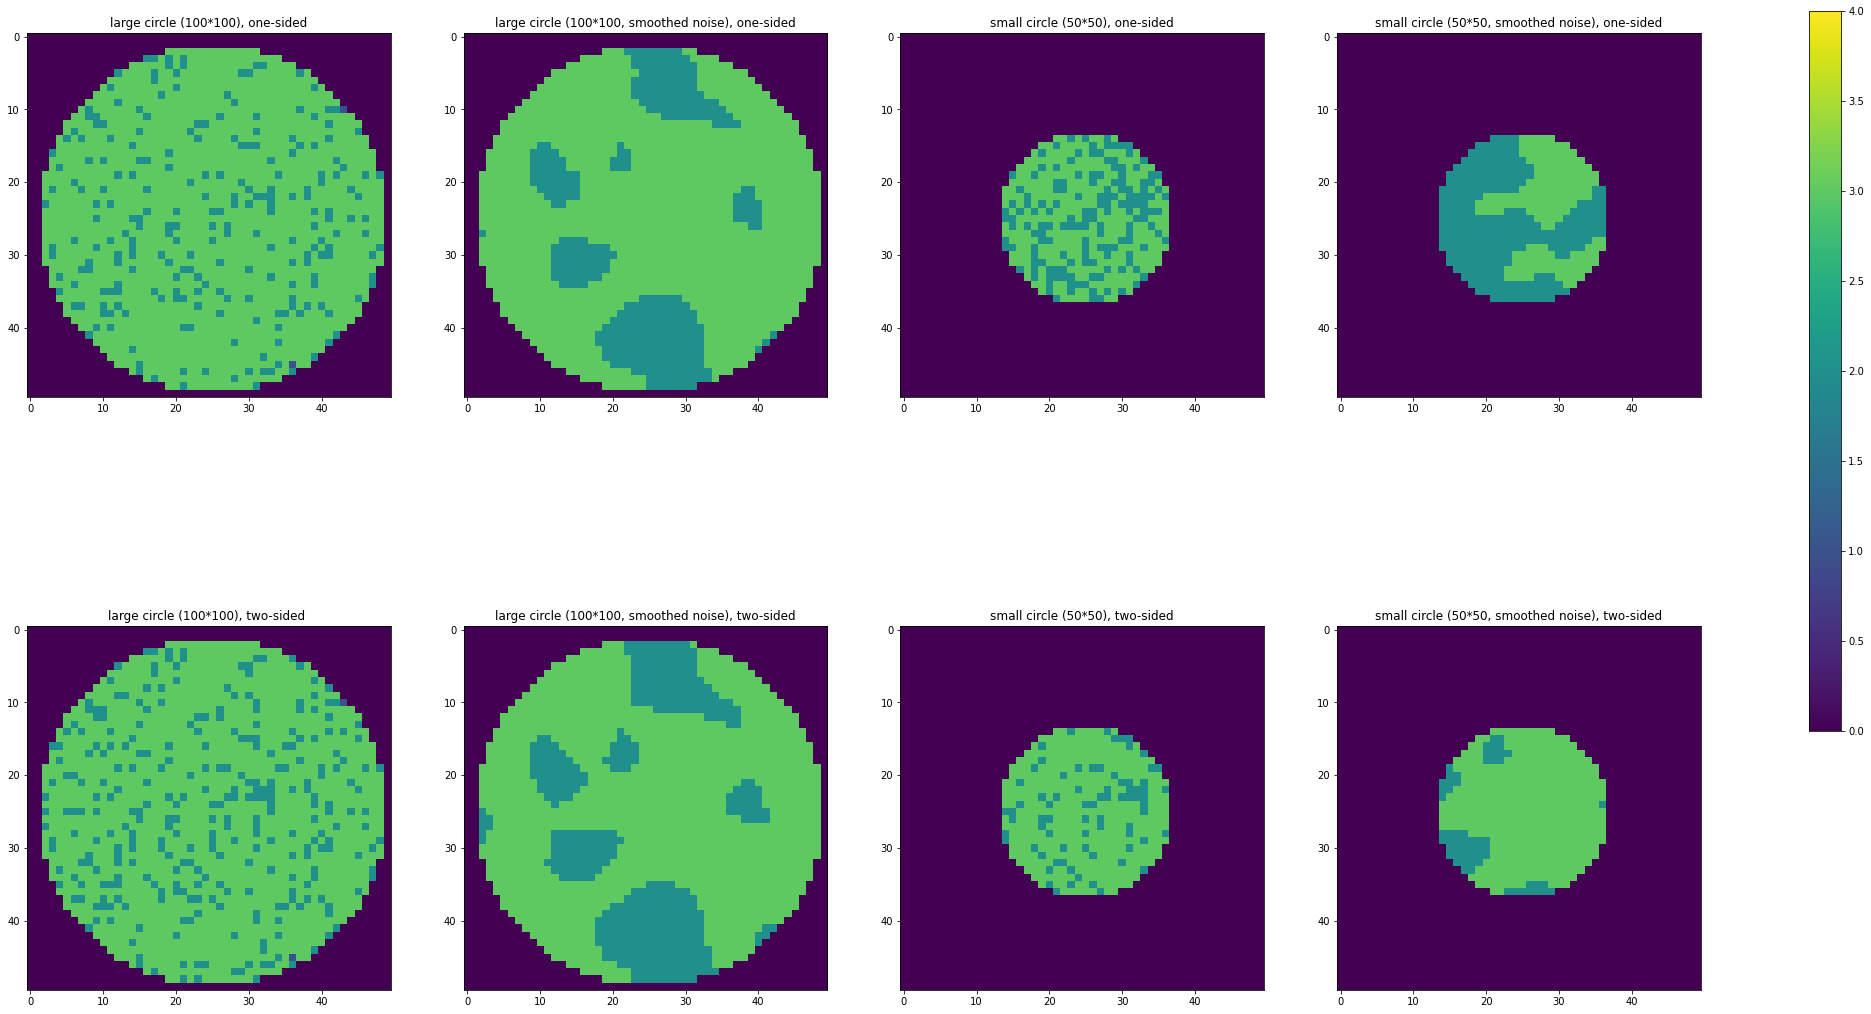

In [182]:
lowerl, upperl, Achatl, Acircular_l1 = fdr_cope(circular_l, threshold=2, alpha=0.05, tail="one")
lowerl2, upperl2, Achatl2, Acircular_l2 = fdr_cope(circular_l, threshold=2, alpha=0.05, tail="two")


lowerl3, upperl3, Achatl3, Acircular_l31 = fdr_cope(circular_l_smth, threshold=2, alpha=0.05, tail="one")
lowerl32, upperl32, Achatl32, Acircular_l32 = fdr_cope(circular_l_smth, threshold=2, alpha=0.05, tail="two")


lowers1, uppers1, Achats1, Acircular_s1 = fdr_cope(circular_s, threshold=2, alpha=0.05, tail="one")
lowers2, uppers2, Achats2, Acircular_s2 = fdr_cope(circular_s, threshold=2, alpha=0.05, tail="two")


lowers31, uppers31, Achats31, Acircular_s31 = fdr_cope(circular_s_smth, threshold=2, alpha=0.05, tail="one")
lowers32, uppers32, Achats32, Acircular_s32 = fdr_cope(circular_s_smth, threshold=2, alpha=0.05, tail="two")



fig, axs = plt.subplots(2, 4, figsize=(30, 20))

_min, _max = 0,4

im = axs[0, 0].imshow(Acircular_l1, vmin = _min, vmax = _max)
axs[0, 0].set_title("large circle (100*100), one-sided")
#plt.colorbar(im00, ax=axs[0, 0])

im = axs[1, 0].imshow(Acircular_l2, vmin = _min, vmax = _max)
axs[1, 0].set_title("large circle (100*100), two-sided ")
#plt.colorbar(im01, ax=axs[0, 1])

im = axs[0, 1].imshow(Acircular_l31, vmin = _min, vmax = _max)
axs[0, 1].set_title("large circle (100*100, smoothed noise), one-sided")
#plt.colorbar(im02, ax=axs[0, 2])

im = axs[1, 1].imshow(Acircular_l32, vmin = _min, vmax = _max)
axs[1, 1].set_title("large circle (100*100, smoothed noise), two-sided")
#plt.colorbar(im03, ax=axs[0, 3])

im = axs[0, 2].imshow(Acircular_s1, vmin = _min, vmax = _max)
axs[0, 2].set_title("small circle (50*50), one-sided")
#plt.colorbar(im00, ax=axs[0, 0])

im = axs[1, 2].imshow(Acircular_s2, vmin = _min, vmax = _max)
axs[1, 2].set_title("small circle (50*50), two-sided")
#plt.colorbar(im01, ax=axs[0, 1])

im = axs[0, 3].imshow(Acircular_s31, vmin = _min, vmax = _max)
axs[0, 3].set_title("small circle (50*50, smoothed noise), one-sided")
#plt.colorbar(im02, ax=axs[0, 2])

im = axs[1, 3].imshow(Acircular_s32, vmin = _min, vmax = _max)
axs[1, 3].set_title("small circle (50*50, smoothed noise), two-sided")
#plt.colorbar(im03, ax=axs[0, 3])

cbar_ax = fig.add_axes([0.95, 0.35, 0.015, 0.5])
fig.colorbar(im, cax=cbar_ax)

plt.show()




# FDR and coverage

## False Discovery Rate




1) FDR inclusion: $\{\hat{A}_c^+ \subset A_c \subset \hat{A}_c^-\}$ check for 1000 iterations ???????


In [ ]:
def fdr_error_check(n_subj, img_dim, c, noise_set, mu_set,
                    var=1, alpha=0.05, tail="two"):
  
  data_dim = np.array((n_subj,) + img_dim)
  noise = get_noise(noise_set, data_dim)*var
  mu = get_mu(mu_set, data_dim)
  data = mu + noise

  lower, upper, Achat, all_sets = fdr_cope(data, threshold=c, alpha=0.05, tail=tail)
  Ac = mu>=c
  AcC = 1-Ac
  upper_inclusion = 1 - np.any( AcC * upper > 0 )
  lower_inclusion = 1 - np.any( Ac * (1-lower)> 0 )
  inclusion = upper_inclusion * lower_inclusion
  return(inclusion)


inclusion = []
sim_num = 1000
for i in np.arange(sim_num):
  inclusion_temp = fdr_error_check(n_subj=80, img_dim=(50,50), c=3, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two")
  inclusion.append(inclusion_temp)

print( np.sum(inclusion)/sim_num)



0.534


2) FDR: $E\frac{| \{\hat{A}_c^+ - A_c\} 𝖴 \{ A_c - \hat{A}_c^-\} |} { | \hat{A}_c^+ 𝖴  \hat{A}_c^{-c} |  }  $ check


In [183]:
def fdr_error_check2(n_subj, img_dim, c, noise_set, mu_set,
                     var=1, alpha=0.05, tail="two"):
  
  data_dim = np.array((n_subj,) + img_dim)
  noise = get_noise(noise_set, data_dim)*var
  mu = get_mu(mu_set, data_dim)
  data = mu + noise

  lower, upper, Achat, all_sets = fdr_cope(data, threshold=c, alpha=0.05, tail=tail)
  Ac = mu>=c
  AcC = 1-Ac
  
  numer = np.sum(np.minimum(np.maximum(upper - Ac.astype(int), 0) + np.maximum(Ac.astype(int) - lower, 0), 1))
  denom = np.sum(np.minimum(upper + (1-lower), 1) )
  if denom == 0:
    ERR = math.nan
  else:
    ERR = numer / denom
  return(ERR)




In [185]:
sim_num = 500
ERR = dict()
ERR['lab'] = ["c=0.5", "c=2", "c=3",
               "c=0.5/std=*3", "c=2/std=*3", "c=3/std=*3"]
ERR['small'] = [[],[],[],[],[],[]]
for i in np.arange(sim_num):
  ERR['small'][0].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=0.5, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))
  ERR['small'][1].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=2, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))
  ERR['small'][2].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=3, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))
  ERR['small'][3].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=0.5, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))
  ERR['small'][4].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=2, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))
  ERR['small'][5].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=3, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))

ERR['small_smth'] = [[],[],[],[],[],[]]
for i in np.arange(sim_num):
  ERR['small_smth'][0].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=0.5, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))
  ERR['small_smth'][1].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=2, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))
  ERR['small_smth'][2].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=3, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))
  ERR['small_smth'][3].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=0.5, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))
  ERR['small_smth'][4].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=2, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))
  ERR['small_smth'][5].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=3, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_50,
                    alpha=0.05, tail="two"))

ERR['large'] = [[],[],[],[],[],[]]
for i in np.arange(sim_num):
  ERR['large'][0].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=0.5, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))
  ERR['large'][1].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=2, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))
  ERR['large'][2].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=3, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))
  ERR['large'][3].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=0.5, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))
  ERR['large'][4].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=2, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))
  ERR['large'][5].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=3, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))
  
ERR['large_smth'] = [[],[],[],[],[],[]]
for i in np.arange(sim_num):
  ERR['large_smth'][0].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=0.5, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))
  ERR['large_smth'][1].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=2, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))
  ERR['large_smth'][2].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=3, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))
  ERR['large_smth'][3].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=0.5, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))
  ERR['large_smth'][4].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=2, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))
  ERR['large_smth'][5].append(fdr_error_check2(n_subj=80, img_dim=(50,50), c=3, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_50,
                    alpha=0.05, tail="two"))


ERR.update({n: np.round(np.nanmean(ERR[n],axis=1),4) for n in list(ERR.keys())[1:]})


In [186]:
sim_num = 500
ERR2 = dict()
ERR2['lab'] = ["c=0.5", "c=2", "c=3",
               "c=0.5/std=*3", "c=2/std=*3", "c=3/std=*3"]
ERR2['small'] = [[],[],[],[],[],[]]
for i in np.arange(sim_num):
  ERR2['small'][0].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=0.5, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))
  ERR2['small'][1].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=2, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))
  ERR2['small'][2].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=3, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))
  ERR2['small'][3].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=0.5, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))
  ERR2['small'][4].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=2, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))
  ERR2['small'][5].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=3, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))

ERR2['small_smth'] = [[],[],[],[],[],[]]
for i in np.arange(sim_num):
  ERR2['small_smth'][0].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=0.5, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))
  ERR2['small_smth'][1].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=2, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))
  ERR2['small_smth'][2].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=3, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))
  ERR2['small_smth'][3].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=0.5, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))
  ERR2['small_smth'][4].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=2, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))
  ERR2['small_smth'][5].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=3, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_s_100,
                    alpha=0.05, tail="two"))

ERR2['large'] = [[],[],[],[],[],[]]
for i in np.arange(sim_num):
  ERR2['large'][0].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=0.5, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))
  ERR2['large'][1].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=2, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))
  ERR2['large'][2].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=3, var=1,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))
  ERR2['large'][3].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=0.5, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))
  ERR2['large'][4].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=2, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))
  ERR2['large'][5].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=3, var=3,
                    noise_set=noise_spec_homogen, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))
  
ERR2['large_smth'] = [[],[],[],[],[],[]]
for i in np.arange(sim_num):
  ERR2['large_smth'][0].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=0.5, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))
  ERR2['large_smth'][1].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=2, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))
  ERR2['large_smth'][2].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=3, var=1,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))
  ERR2['large_smth'][3].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=0.5, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))
  ERR2['large_smth'][4].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=2, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))
  ERR2['large_smth'][5].append(fdr_error_check2(n_subj=80, img_dim=(100,100), c=3, var=3,
                    noise_set=noise_spec_homogen_smth, mu_set=mu_spec_circle_l_100,
                    alpha=0.05, tail="two"))

ERR2.update({n: np.round(np.nanmean(ERR2[n],axis=1),4) for n in list(ERR2.keys())[1:]})


In [190]:
print("--------------------imagesize:(50*50)--------------------")
print(tabulate(ERR, headers="keys"))
print()
print()
print("--------------------imagesize:(100*100)--------------------")
print(tabulate(ERR2, headers="keys"))
print()
print("!some settings yielded no upper/lower set -> excluded from mean calculation!")

--------------------imagesize:(50*50)--------------------
lab             small    small_smth    large    large_smth
------------  -------  ------------  -------  ------------
c=0.5          0.0001        0.0001   0.0001        0.0001
c=2            0             0        0             0
c=3            0.0045        0.0041   0.0182        0.0174
c=0.5/std=*3   0.0042        0.006    0.0019        0.002
c=2/std=*3     0.0002        0.0001   0.0006        0.0005
c=3/std=*3     0.0043        0.0041   0.018         0.018


--------------------imagesize:(100*100)--------------------
lab             small    small_smth    large    large_smth
------------  -------  ------------  -------  ------------
c=0.5          0.0001        0.0001   0.0001        0.0001
c=2            0             0        0             0
c=3            0.0048        0.0049   0.0188        0.0197
c=0.5/std=*3   0.0038        0.0036   0.0016        0.0017
c=2/std=*3     0.0002        0.0002   0.0004        0.0007
c=3/std

No inference on upper/lower confidence set (no rejection from BH)

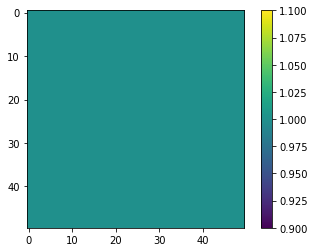

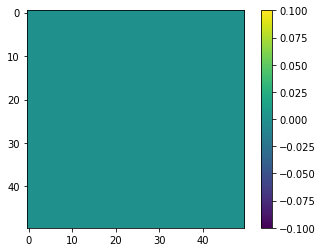

In [198]:
  n_subj=80
  img_dim=(50,50)
  c=0.5; var=3
  noise_set=noise_spec_homogen_smth
  alpha=0.05; tail="two"

  
  data_dim = np.array((n_subj,) + img_dim)
  noise = get_noise(noise_set, data_dim)*var
  mu = get_mu(mu_spec_circle_s_50, data_dim)
  data = mu + noise

  lower, upper, Achat, all_sets = fdr_cope(data, threshold=c, alpha=0.05, tail=tail)
  plt.imshow(lower)
  plt.colorbar()
  plt.show()
  plt.imshow(upper)
  plt.colorbar()
  plt.show()